In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
IBMQ.save_account('7d51f5c5e5c7521015c58312ad6428df9fc7dcf957d3159dfba1f25c77afdbee41b8ae64d75b87285e51cd8d0b28c172a4a13c2491283414a1d489281fb5a2f1')
provider = IBMQ.load_account()

/tmp/ipykernel_5543/1247502325.py:11: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.save_account('7d51f5c5e5c7521015c58312ad6428df9fc7dcf957d3159dfba1f25c77afdbee41b8ae64d75b87285e51cd8d0b28c172a4a13c2491283414a1d489281fb5a2f1')
configrc.store_credentials:WARNING:2023-02-28 18:32:00,619: Credentials already present. Set overwrite=True to overwrite.


In [2]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
driver_ana = PySCFDriver(
    atom="H 0 0 0; Be 0 0 1.334; H 0 0 2.668",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
problem_ana = ElectronicStructureProblem(
        driver_ana,
        [FreezeCoreTransformer(freeze_core=False)])
    
problem_ana = driver_ana.run()

from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, QubitConverter

solver = GroundStateEigensolver(
    QubitConverter(ParityMapper()),
    NumPyMinimumEigensolverFactory(),
)

result = solver.solve(problem_ana)
ana_gs = result.total_energies[0]
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -18.966849762441
  - computed part:      -18.966849762441
~ Nuclear repulsion energy (Hartree): 3.37181881021
> Total ground state energy (Hartree): -15.595030952231
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 6.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  15.1253679]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  15.1253679]
    - computed part:      [0.0  0.0  15.1253679]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


In [3]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)

# Define Molecule
molecule = Molecule(
    # Coordinates in Angstrom
    geometry=[
        ["H", [0.0, 0.0, 0.0]],
        ["Be", [1.334, 0.0, 0.0]],
        ["H", [2.668, 0.0, 0.0]]
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF)

In [4]:
# Define Problem, Use freeze core approximation, remove orbitals.
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

problem = ElectronicStructureProblem(
    driver,
    [FreezeCoreTransformer(freeze_core=True, remove_orbitals=[2,3])])

second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles

In [5]:
from qiskit.opflow import TwoQubitReduction
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, QubitConverter
mapper = ParityMapper()#JordanWignerMapper()
converter = QubitConverter(mapper, two_qubit_reduction=True)
hamiltonian = second_q_ops['ElectronicEnergy']
qubit_op = converter.convert(hamiltonian)
reducer = TwoQubitReduction(num_particles)
qubit_op = reducer.convert(qubit_op)
num_particles = num_particles
num_spin_orbitals = num_spin_orbitals -2

In [6]:
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import ExcitationPreserving
from qiskit.circuit import Parameter
from qiskit.circuit.library import TwoLocal

var = QuantumCircuit(4)
var.x(0)
var.x(1)

for i in range(4):
    var.rx(Parameter('ax_' + str(i)), i)
var.append(ExcitationPreserving(2,reps=0, parameter_prefix='b'), [0,2])
var.append(ExcitationPreserving(2,reps=0, parameter_prefix='c'), [1,3])
#var.append(ExcitationPreserving(2,reps=0, parameter_prefix='d'), [2,5])

In [7]:
var.draw()

┌───┐    ┌──────────┐┌──────────────────────────────────┐»
q_0: ───┤ X ├────┤ Rx(ax_0) ├┤0                                 ├»
        ├───┤    ├──────────┤│                                  │»
q_1: ───┤ X ├────┤ Rx(ax_1) ├┤  ExcitationPreserving(b[0],b[1]) ├»
     ┌──┴───┴───┐└──────────┘│                                  │»
q_2: ┤ Rx(ax_2) ├────────────┤1                                 ├»
     ├──────────┤            └──────────────────────────────────┘»
q_3: ┤ Rx(ax_3) ├────────────────────────────────────────────────»
     └──────────┘                                                »
«                                         
«q_0: ────────────────────────────────────
«     ┌──────────────────────────────────┐
«q_1: ┤0                                 ├
«     │                                  │
«q_2: ┤  ExcitationPreserving(c[0],c[1]) ├
«     │                                  │
«q_3: ┤1                                 ├
«     └──────────────────────────────────┘

In [10]:
from circuit_knitting_toolbox.entanglement_forging import EntanglementForgingAnsatz

ansatz = EntanglementForgingAnsatz(
    circuit_u=var,
    bitstrings_u=[(1, 1, 1,1), (0, 0, 0,0)],
)

ansatz.circuit_u.draw()

┌───┐    ┌──────────┐┌──────────────────────────────────┐»
q_0: ───┤ X ├────┤ Rx(ax_0) ├┤0                                 ├»
        ├───┤    ├──────────┤│                                  │»
q_1: ───┤ X ├────┤ Rx(ax_1) ├┤  ExcitationPreserving(b[0],b[1]) ├»
     ┌──┴───┴───┐└──────────┘│                                  │»
q_2: ┤ Rx(ax_2) ├────────────┤1                                 ├»
     ├──────────┤            └──────────────────────────────────┘»
q_3: ┤ Rx(ax_3) ├────────────────────────────────────────────────»
     └──────────┘                                                »
«                                         
«q_0: ────────────────────────────────────
«     ┌──────────────────────────────────┐
«q_1: ┤0                                 ├
«     │                                  │
«q_2: ┤  ExcitationPreserving(c[0],c[1]) ├
«     │                                  │
«q_3: ┤1                                 ├
«     └──────────────────────────────────┘

Ideal Simulation

In [11]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options

# By default, use a local simulator to implement the Qiskit Runtime Primitives
service = None

# Uncomment the following line to instead use the Qiskit Runtime Service.
# service = QiskitRuntimeService(channel="ibm_quantum")

backend_names = ["ibmq_qasm_simulator"] * 2

# If a single set of options are passed, it will be applied to all backends
options = [Options(execution={"shots": 1000}), Options(execution={"shots": 1000})]

In [15]:
from circuit_knitting_toolbox.entanglement_forging import (
    EntanglementForgingGroundStateSolver,
)
from qiskit.algorithms.optimizers import COBYLA
optimizer = COBYLA(maxiter=100)
solver = EntanglementForgingGroundStateSolver(
    ansatz=ansatz,
    optimizer=optimizer,
    service=service,
    backend_names=backend_names,
    options=options,
    #initial_point=[0.0]*var.num_parameters,
)

In [16]:
%%capture

results = solver.solve(problem)

Energy:


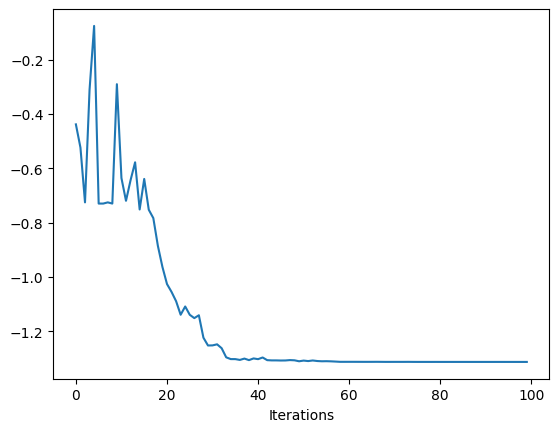

Schmidt Coefficients:


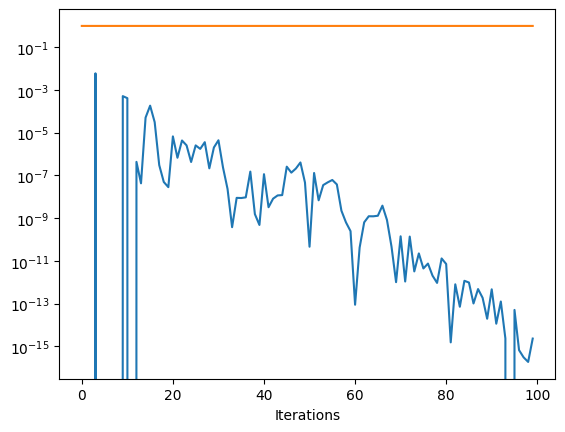

Parameters:


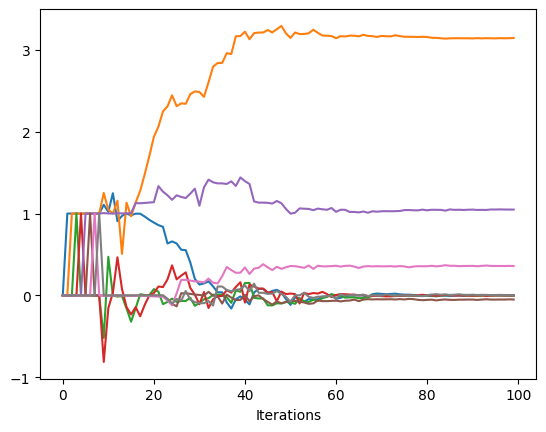

In [17]:
import matplotlib.pyplot as plt

print("Energy:")
plt.plot([evaluation.eigenvalue for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
plt.plot([abs(evaluation.eigenstate) for evaluation in results.history])
plt.xlabel("Iterations")
plt.yscale("log")
plt.show()

print("Parameters:")
plt.plot([evaluation.parameters for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

In [18]:
cmp_gs = results.groundenergy+(-17.61951586276)+3.37181881021

In [19]:
print(cmp_gs)
print(ana_gs)
print((ana_gs-cmp_gs)/ana_gs*100)

-15.559838181510107
-15.59503095223095
0.225666565386378


Noisy Simulation

In [185]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options

# By default, use a local simulator to implement the Qiskit Runtime Primitives
service = None

# Uncomment the following line to instead use the Qiskit Runtime Service.
# service = QiskitRuntimeService(channel="ibm_quantum")

backend_names = ['simulator_statevector']*2#["ibmq_qasm_simulator"] * 2

# If a single set of options are passed, it will be applied to all backends
options = [Options(execution={"shots": 1000}), Options(execution={"shots": 2000})]

In [186]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator as RuntimeEstimator, Options
QiskitRuntimeService.save_account(channel="ibm_quantum", token='7d51f5c5e5c7521015c58312ad6428df9fc7dcf957d3159dfba1f25c77afdbee41b8ae64d75b87285e51cd8d0b28c172a4a13c2491283414a1d489281fb5a2f1' ,overwrite=True)

In [189]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='deloitte-event23/level-1-access/the-entangled-ca',
)
backend = service.get_backend('ibmq_lima')
print(backend)
qubit_layout=[0,1,2,3]

<IBMBackend('ibmq_lima')>


In [192]:
from qiskit.algorithms.optimizers import COBYLA
from qiskit_aer.noise import NoiseModel
from circuit_knitting_toolbox.entanglement_forging import (
    EntanglementForgingGroundStateSolver,
)

optimizer = COBYLA(maxiter=100)

options = Options()
options.execution.shots = 1024
options.optimization_level = 3
options.resilience_level = 2
options.noise_model= NoiseModel.from_backend(backend)


In [194]:
solver = EntanglementForgingGroundStateSolver(
    ansatz=ansatz,
    optimizer=optimizer,
    service=service,
    backend_names=backend_names,
    options=options,
    #initial_point=[0.0]*var.num_parameters,
)

In [195]:
%%capture

results = solver.solve(problem)

Energy:


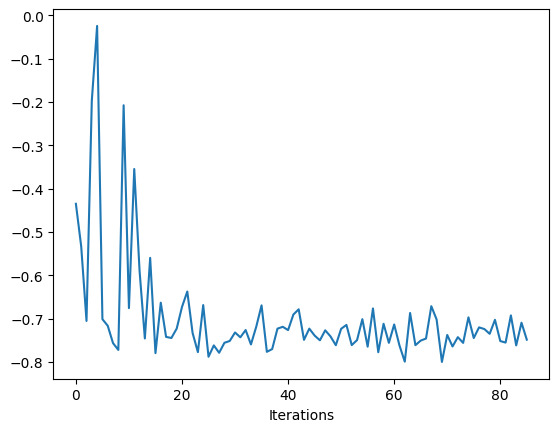

Schmidt Coefficients:


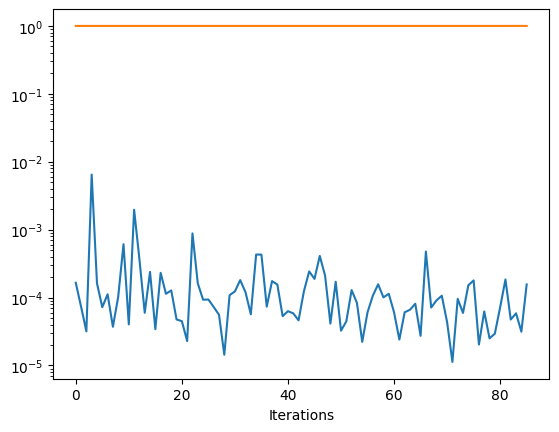

Parameters:


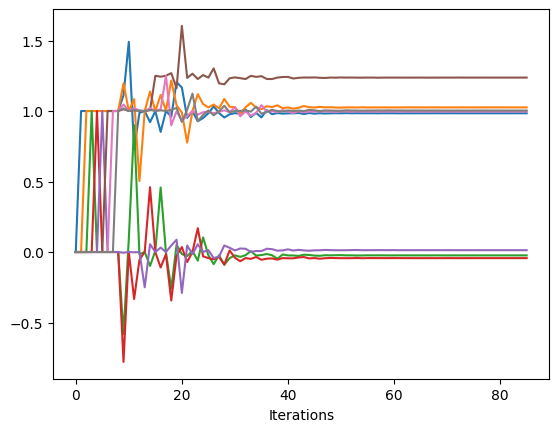

In [196]:
import matplotlib.pyplot as plt

print("Energy:")
plt.plot([evaluation.eigenvalue for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
plt.plot([abs(evaluation.eigenstate) for evaluation in results.history])
plt.xlabel("Iterations")
plt.yscale("log")
plt.show()

print("Parameters:")
plt.plot([evaluation.parameters for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

In [198]:
cmp_gs = results.groundenergy+(-17.61951586276)+3.37181881021

In [199]:
print(cmp_gs)
print(ana_gs)
print((ana_gs-cmp_gs)/ana_gs*100)

-15.04750952337619
-15.595030952230633
3.510871062273387
